In [1]:
# Jacob van Rosmalen s1007344

# Exercises

## Exercise 1: Image characteristics
---

**A.** Distiguishing pixels   

Fluctuations in the activitation of the neuron can be directly observed on the video or in a temporal trace plot of each pixel. Plotting the temporal trace will allow us to see the calcium transient dinamic, if a pixel belonging to a neuron is selected. 

* Select a set of *N* random pixels from the ROI and plot the temporal evolution of pixel value. If the random pixels are choosen from an active neuron, you will be able to see the calcium transcient dynamic. Try this a few time to appreciate the results.

**B.** Temporal statistics of pixel activation
 * For the selected pixels, plot the histogram of pixel value. What are the difference in different regions?, and how can that help to distinguish a pixel that belongs to aneuron from a background pixel?

* If we can already see the calcium traces from individual pixels, why do we need to run source extraction to segment the neurons? Why, as a starter, would not be a good idea to work directly with the temporal traces of the pixels? 

In [2]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import psutil
from pathlib import Path
import os

# CaImAn funtions and objects
import caiman as cm
from caiman.motion_correction import MotionCorrect, high_pass_filter_space
from caiman.source_extraction.cnmf import params as params
from caiman.source_extraction import cnmf
from caiman.source_extraction.cnmf.cnmf import load_CNMF

import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data
import auxiliary_functions as aux


import seaborn as sns
sns.set_theme(context='notebook',style='white',font_scale=1.5)

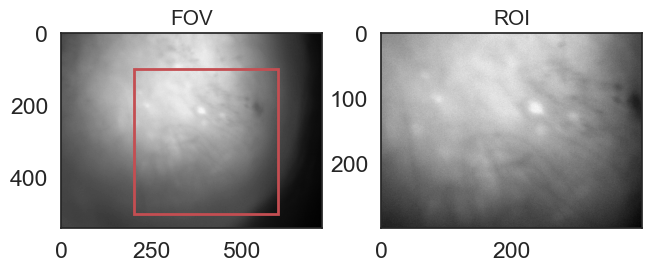

In [3]:
# set path to video of the full field of view
input_tif_file_path_FOV = 'data/calcium_video.tif'   
input_tif_file_path = 'data/caiman_video_trial_0.tif'  
FOV = cm.load(input_tif_file_path_FOV) # load video with complete field of view (FOV)
# Let's visualize the FOV and the ROI
aux.plot_FOV(FOV_file = input_tif_file_path_FOV , ROI_file = input_tif_file_path)

(300, 540, 720)
(500, 300, 400)
(500, 500)
Range: [326.0,1220.0]


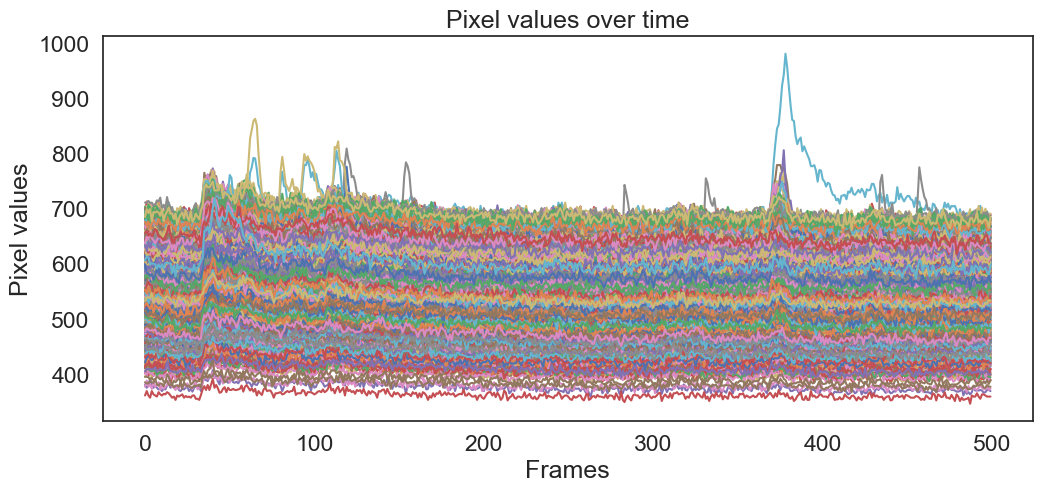

In [4]:
# 1A
print(FOV.shape)
ROI = cm.load(input_tif_file_path)
print(ROI.shape)
frames, ypixels, xpixels = ROI.shape
N = 500
image_size = ypixels * xpixels
random_pixels_index = np.random.randint(0, image_size, N)
flattened_ROI = ROI.reshape(frames, image_size)
random_pixels = flattened_ROI[:, random_pixels_index]
print(random_pixels.shape)
print(f'Range: [{ROI.min()},{ROI.max()}]')

plt.figure(figsize = (12,5))
plt.plot(random_pixels)
plt.title('Pixel values over time')
plt.xlabel('Frames')
plt.ylabel('Pixel values')
plt.show()

In [5]:
flat_index = np.argmax(ROI)

max_index = np.unravel_index(flat_index, ROI.shape)
print(max_index)
print(ROI[max_index])

(378, 119, 240)
1220.0


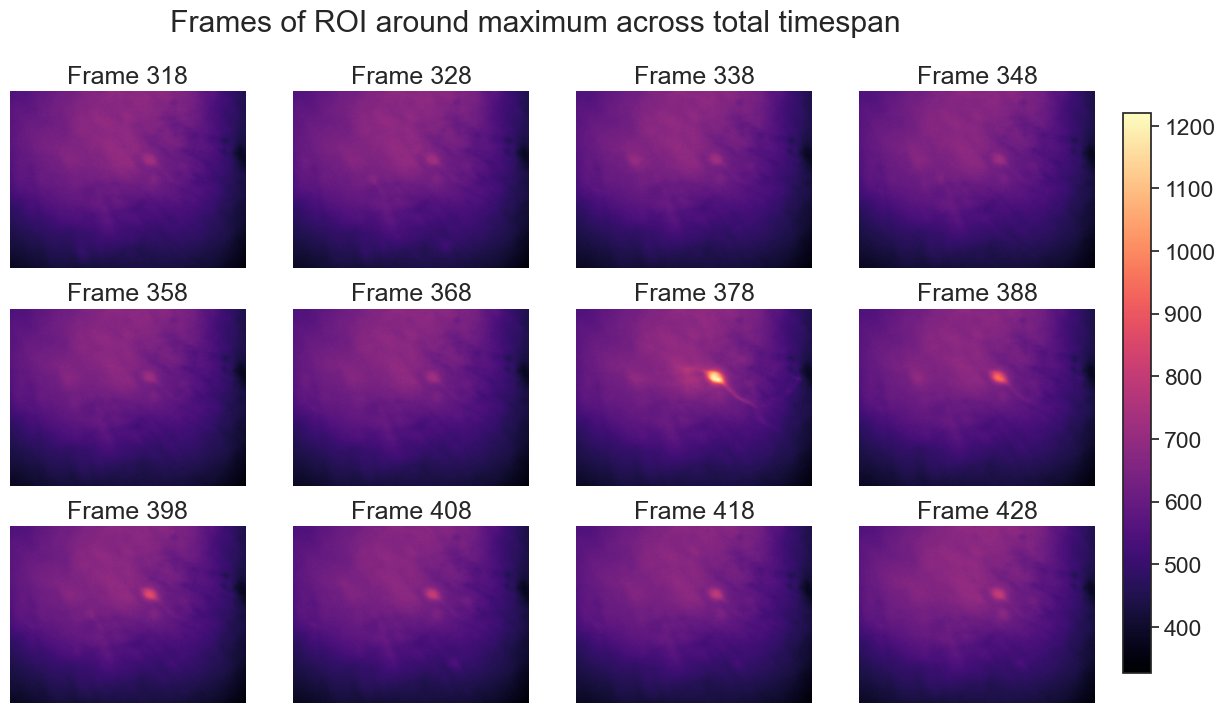

In [6]:
frame_max = max_index[0]

frame_steps = np.arange(frame_max - 60, frame_max + 60, 10)

frame_steps = np.clip(frame_steps, 0, ROI.shape[0] - 1)

fig, axes = plt.subplots(3, 4, figsize=(14, 8))  # 3 rows, 4 columns
axes = axes.flatten()

vmin = ROI.min()
vmax = ROI.max()

for i, frame in enumerate(frame_steps):
    ax = axes[i]
    im = ax.imshow(ROI[frame], cmap = 'magma', vmin=vmin, vmax=vmax)
    ax.set_title(f"Frame {frame}")
    ax.axis('off')

plt.suptitle("Frames of ROI around maximum across total timespan")
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

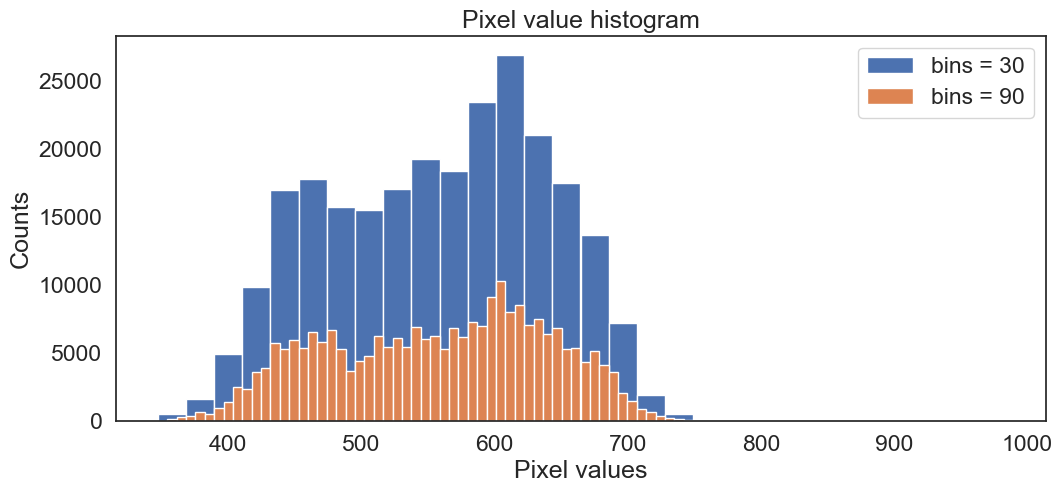

In [7]:
plt.figure(figsize = (12,5)) 
nrbins = 30
counts, bins = np.histogram(random_pixels, bins = nrbins)
nrbins2 = nrbins*3
counts2, bins2 = np.histogram(random_pixels, bins = nrbins2)
plt.hist(bins[:-1], bins, weights=counts, label = f'bins = {nrbins}')
plt.hist(bins2[:-1], bins2, weights=counts2, label = f'bins = {nrbins2}')
plt.title('Pixel value histogram')
plt.xlabel('Pixel values')
plt.ylabel('Counts')
plt.legend()
plt.show()

In the pixel value histogram you can see gaps between groups of pixel values. This probably indicates two distributions, probably one corresponding to background (consisting of lower values) and the other to neurons (consisting of higher values). And also in the temporal plot you can see the lower pixel values dont fluctuate as much as the higher value onces (which are probably neurons). This could be further cemented by creating a plot of the standard deviation of each pixel versus its average value. In the temporal plot you can also see spikes, so those pixels most likely belong to a neuron thats spiking at that point in time. However as this video isn't corrected for any movement, iow. not stabilized, that means that pixels that belonged to a neuron at one point could not belong to the same neuron anymore at another point. Therefore one trace in the temporal plot made from an unstabilized ROI is not reliably indicating the activity of a singular neuron.

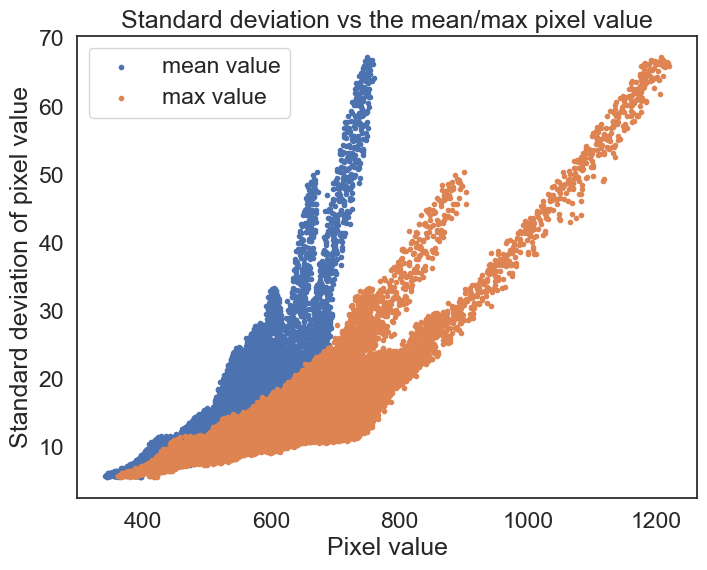

In [8]:
plt.figure(figsize = (8,6))
plt.scatter(np.mean(flattened_ROI, axis = 0), np.std(flattened_ROI, axis = 0), marker = '.', label = 'mean value')
plt.scatter(np.max(flattened_ROI, axis = 0), np.std(flattened_ROI, axis = 0), marker = '.', label = 'max value')
plt.legend()
plt.xlabel('Pixel value')
plt.ylabel('Standard deviation of pixel value')
plt.title('Standard deviation vs the mean/max pixel value')
plt.show()


This result confirms the belief that the 2nd distribution (around 600+ pixel value) consists more of neurons, as the std of (some of) these pixels is much higher, most likely due to spiking.

## Exercise 2: motion correction parameters
---

One parameter that impacts motion correction performance is the size of the spatial filter that is applyed to the video.

* Use the following function from CaImAn and plot the result of different space filtering applyed to a single frame of the video:from caiman.motion_correction import high_pass_filter_space

* How will this filtering affect the measure of crispness?

* Acording to Pnevmatikakis et al, which other factors are relevant for pw-rigid motion correction?

- Explore the impact of different parameters in the output of motion correction algorithm by measuring crispness in the correlation image of the final outcome. Particularly measure the effect of different spatial filter size by applying motion correction algorithm multiple times and computing the crispness of the output video. 

- Display all crispness values for rigid and not rigid motion correction and plot them agains gSig_filters values.

- If possible, show the impact of the crispness value that comes from changing other relevant paraments.

*Note1: The is no need to save all the motion corrected movies, just save the cripsness values.*

*Note2: gSig_filters is an optional range of posible values, but if your computer gets to slow in the computation reduce the range.*


## Exercise 3: Source extraction parameters 
---

* For a fixed minimum correlation value (ie 0.6) select a range of possible PNR minimun values and study the impact of those in the final source extraction output.

* For a fixed value of PNR (ie 6) select a range of minimum correlation valur and study the impact of those in the final source extraction output.

* How do these paramenters affect the spatial sparcity of the output? Which set of parameter selection procedes the higher number of neurons? Is maximal number of neurons always better? Why?  

* Generate a plot of number of neurons vs PNR (or min corr value) to show how these parameters affect the source extracted signals.

* Are the temporal traces affected by these parameters?

* For different PNR and minimum correlation value plot the correlation image and the selected cells.